# 신용정보 EDA

In [1]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 설치된 폰트 목록을 갱신하고, 'NanumGothic' 폰트를 기본 폰트로 설정합니다.
font_path = 'C:/Windows/Fonts/NanumGothic.ttf' 
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

import sys
sys.path.append('../utils')

In [2]:
from sklearn.pipeline import Pipeline
from sklearn import set_config
from preprocessing import (
    DateElapsedTransformer, NumericFeaturePreprocessor, ObjectFeaturePreprocessor, NumericTypeOptimizer,
)

pre_optimizer = NumericTypeOptimizer(mode='pre')
date_transformer = DateElapsedTransformer()
numeric_transformer = NumericFeaturePreprocessor()
object_transformer = ObjectFeaturePreprocessor()
post_optimizer = NumericTypeOptimizer(mode='post')

preprocessing_pipeline = Pipeline([
    ('pre_optimizer', pre_optimizer),
    ('date', date_transformer),
    ('object', object_transformer),
    ('numeric', numeric_transformer),
    ('post_optimizer', post_optimizer),
])

# Set display configuration to visualize the pipeline
set_config(display='diagram')

# Display the pipeline
preprocessing_pipeline

Pipeline(steps=[('pre_optimizer', NumericTypeOptimizer(mode='pre')),
                ('date',
                 DateElapsedTransformer(base_date=Timestamp('2019-01-01 00:00:00'),
                                        exclude_columns=['ID', 'Segment',
                                                         '기준년월'])),
                ('object',
                 ObjectFeaturePreprocessor(exclude_columns=['ID', 'Segment'])),
                ('numeric',
                 NumericFeaturePreprocessor(exclude_columns=['기준년월'])),
                ('post_optimizer', NumericTypeOptimizer())])

In [3]:
from sklearn.preprocessing import LabelEncoder
from data_loader import load_data

credit_df, credit_test_df = load_data("2.신용정보")

X = credit_df.drop(columns=['ID', '기준년월'])
X = preprocessing_pipeline.fit_transform(X)
X.info()

✅ File: ../../dataset/train/2.신용정보\201807_train_신용정보.parquet Completed!
✅ File: ../../dataset/train/2.신용정보\201808_train_신용정보.parquet Completed!
✅ File: ../../dataset/train/2.신용정보\201809_train_신용정보.parquet Completed!
✅ File: ../../dataset/train/2.신용정보\201810_train_신용정보.parquet Completed!
✅ File: ../../dataset/train/2.신용정보\201811_train_신용정보.parquet Completed!
✅ File: ../../dataset/train/2.신용정보\201812_train_신용정보.parquet Completed!
🔹 Shape : (2400000, 42)

✅ File: ../../dataset/test/2.신용정보\201807_test_신용정보.parquet Completed!
✅ File: ../../dataset/test/2.신용정보\201808_test_신용정보.parquet Completed!
✅ File: ../../dataset/test/2.신용정보\201809_test_신용정보.parquet Completed!
✅ File: ../../dataset/test/2.신용정보\201810_test_신용정보.parquet Completed!
✅ File: ../../dataset/test/2.신용정보\201811_test_신용정보.parquet Completed!
✅ File: ../../dataset/test/2.신용정보\201812_test_신용정보.parquet Completed!
🔹 Shape : (600000, 42)
🧠 [mode=pre] 메모리 최적화: 1497.01 MB → 1098.76 MB (26.6% 감소)
Date Elapsed Transformer Fitting...
✅ Total

## Feature Selection

In [19]:
segment_df = pd.read_parquet('../dataset/train/member.parquet', engine='fastparquet')
segment_df = segment_df[['ID', '기준년월', 'Segment']]

credit_df = credit_df.merge(segment_df, on=['ID', '기준년월'], how='left')

In [20]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

def get_feature_importance(X, y, importance_type='gain', plot_top_n=30):
    """
    LightGBM을 이용해 Feature Importance를 계산하고, 상위 feature를 시각화합니다.
    
    Parameters:
    - X (pd.DataFrame): feature 데이터
    - y (pd.Series or np.array): target 데이터
    - importance_type (str): 'gain' 또는 'split' (중요도 기준)
    - plot_top_n (int): 중요도가 높은 feature 몇 개를 plot할지
    - random_state (int): seed 고정

    Returns:
    - feature_importance_df (pd.DataFrame): feature importance 데이터프레임
    - model (lgb.Booster): 학습된 LightGBM 모델
    """

    # LightGBM 데이터셋 구성
    lgb_train = lgb.Dataset(X, label=y)

    # LightGBM 기본 파라미터 (가볍게 학습)
    params = {
        'objective': 'multiclass',   # 다중 클래스 분류
        'num_class': 5,  # 클래스 수 자동 지정
        'boosting_type': 'gbdt',
        'metric': 'multi_logloss',   # 다중 클래스 로지 손실
        'verbosity': -1,
        'seed': 42,
        'learning_rate': 0.05,
        'num_leaves': 31,
        'min_data_in_leaf': 20
    }

    # 빠르게 학습 (에포크 100회로 제한)
    model = lgb.train(params, lgb_train, num_boost_round=100)

    # Feature Importance 가져오기
    importance = model.feature_importance(importance_type=importance_type)
    feature_names = X.columns

    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importance
    }).sort_values('importance', ascending=False)

    # 시각화
    top_features = feature_importance_df.head(plot_top_n)
    
    plt.figure(figsize=(10, max(6, plot_top_n // 2)))
    plt.barh(top_features['feature'][::-1], top_features['importance'][::-1])
    plt.xlabel('Importance')
    plt.title(f'Top {plot_top_n} Feature Importance ({importance_type})')
    plt.tight_layout()
    plt.show()

    return feature_importance_df, model


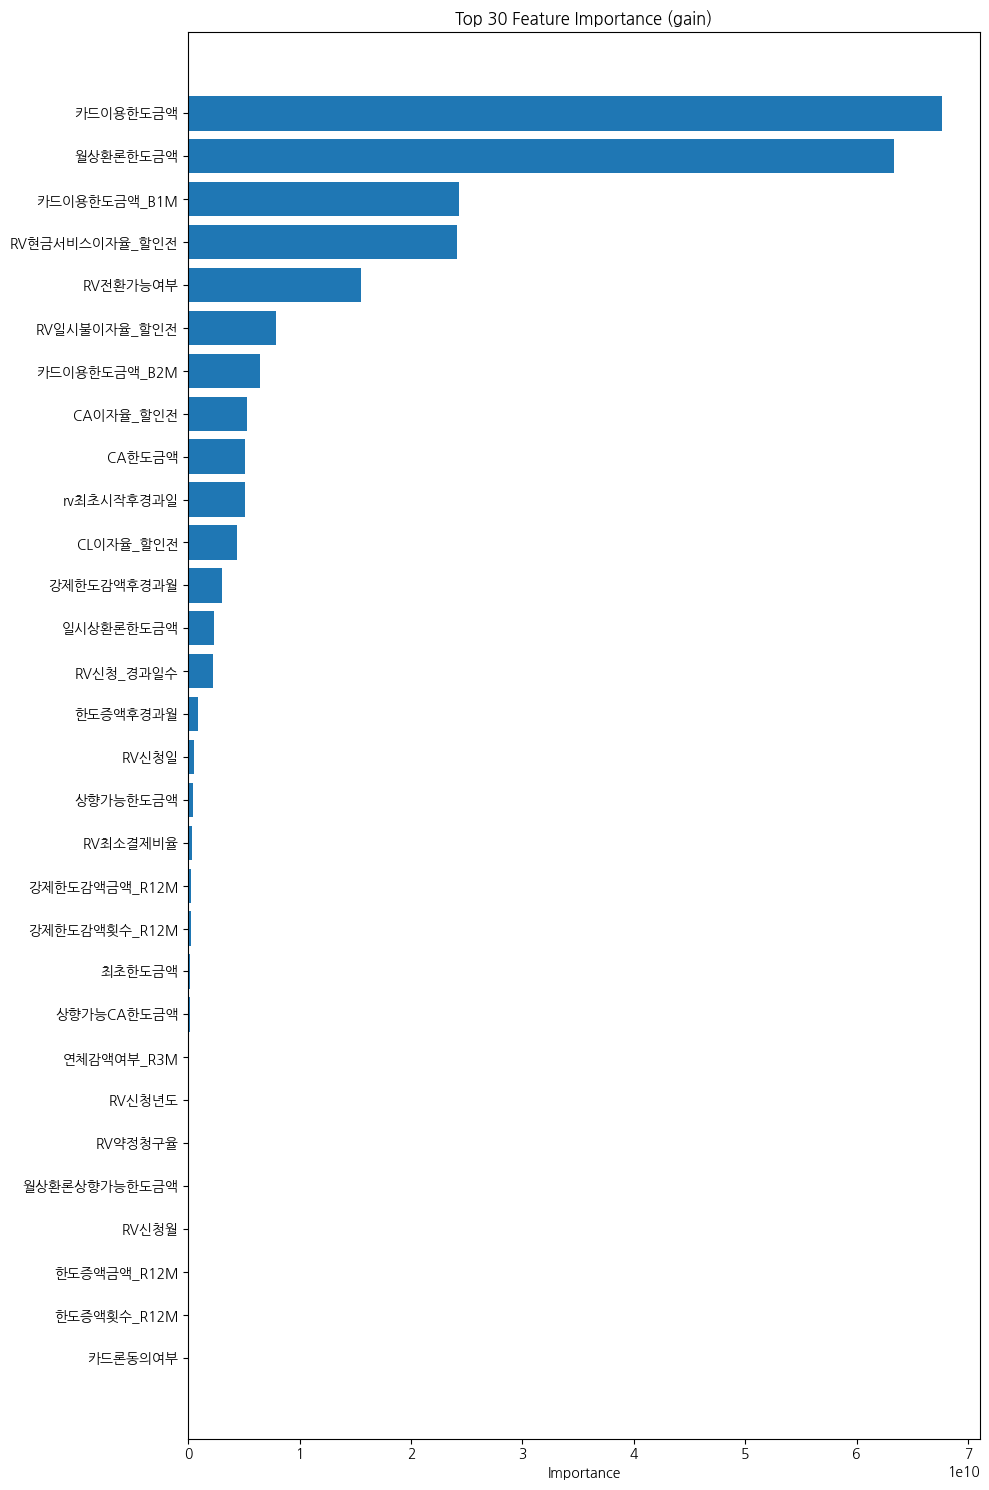

In [21]:
X = credit_df.drop(columns=['ID', '기준년월', 'Segment'])

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y = le.fit_transform(credit_df['Segment'])

importance_df, model = get_feature_importance(X, y, importance_type='gain', plot_top_n=30)

- `rv최초시작후경과일`이 Top 1 Feature
    - 그러나 결측치가 너무 많음.
    - NaN은 리볼빙을 사용하지 않는 고객이 많다는 의미.
    - 모델이 "리볼빙 사용 여부"만 보고 예측하려고 한다면, 실제 비즈니스 해석력이 떨어질 수 있음
    - "리볼빙을 했는가" + "얼마나 오래 사용했는가"를 동시에 담고 있는 복합 feature라고 결론
    - "RV사용여부"라는 새로운 Feature를 생성

In [22]:
def select_top_features(importance_df, X, top_percent=0.3):
    """
    중요도 데이터프레임에서 상위 top_percent 비율만큼 feature를 선택하여 데이터셋 추출

    Parameters:
    - importance_df (pd.DataFrame): feature와 importance를 가진 데이터프레임
    - X (pd.DataFrame): 원본 feature 데이터셋
    - top_percent (float): 상위 몇 %를 선택할지 (기본 30%)

    Returns:
    - X_top (pd.DataFrame): 상위 feature만 선택된 데이터프레임
    - selected_features (list): 선택된 feature 리스트
    """
    n_features = int(len(importance_df) * top_percent)
    selected_features = importance_df['feature'].iloc[:n_features].tolist()
    X_top = X[selected_features]
    return X_top, selected_features

In [23]:
X_top, selected_features = select_top_features(importance_df, X, top_percent=0.3)
print(f"🔹 선택된 feature 수: {len(selected_features)}")
print(f"🔹 선택된 feature: {selected_features}")

🔹 선택된 feature 수: 12
🔹 선택된 feature: ['카드이용한도금액', '월상환론한도금액', '카드이용한도금액_B1M', 'RV현금서비스이자율_할인전', 'RV전환가능여부', 'RV일시불이자율_할인전', '카드이용한도금액_B2M', 'CA이자율_할인전', 'CA한도금액', 'rv최초시작후경과일', 'CL이자율_할인전', '강제한도감액후경과월']


In [26]:
def plot_feature_correlation(X_top, threshold=0.8):
    """
    상위 feature들 간의 상관계수 행렬을 시각화하고, 
    threshold 이상인 feature쌍을 출력

    Parameters:
    - X_top (pd.DataFrame): 상위 feature 데이터프레임
    - threshold (float): 높은 상관관계로 간주할 기준
    """
    # 수치치형 feature만 선택
    numeric_features = X_top.select_dtypes(include=['int', 'float'])
    corr_matrix = numeric_features.corr()

    # 상관관계 히트맵 그리기
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Matrix of Top Features')
    plt.show()

    # threshold 이상인 feature 쌍 출력
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))

    if high_corr_pairs:
        print(f"\n상관계수 {threshold} 이상인 feature 쌍:")
        for f1, f2, corr in sorted(high_corr_pairs, key=lambda x: -abs(x[2])):
            print(f"🔹{f1} vs {f2}: 상관계수 = {corr:.3f}")
    else:
        print(f"\n상관계수 {threshold} 이상인 feature 쌍이 없습니다.")

In [27]:
# 상관계수 0.8 이상인 feature 쌍을 시각화
plot_feature_correlation(X_top, threshold=0.8)

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1200x1000 with 0 Axes>

In [29]:
filtered_credit_df = credit_df[['ID', '기준년월'] + X_top.columns.tolist()]
filtered_credit_df.to_parquet('../dataset/train/credit.parquet', engine='fastparquet', index=False)

filtered_credit_test_df = credit_test_df[['ID', '기준년월'] + X_top.columns.tolist()]
filtered_credit_test_df.to_parquet('../dataset/test/credit.parquet', engine='fastparquet', index=False)